In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
import gc

First the Multi-head Attention

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 d_model: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool=False,
                 dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()

        self.W_q = torch.nn.Linear(d_model, q * h)
        self.W_k = torch.nn.Linear(d_model, q * h)
        self.W_v = torch.nn.Linear(d_model, v * h)

        self.W_o = torch.nn.Linear(v * h, d_model)

        self.device = device
        self._h = h
        self._q = q

        self.mask = mask
        self.dropout = torch.nn.Dropout(p=dropout)
        self.score = None

    def forward(self, x, stage):
        Q = torch.cat(self.W_q(x).chunk(self._h, dim=-1), dim=0)
        K = torch.cat(self.W_k(x).chunk(self._h, dim=-1), dim=0)
        V = torch.cat(self.W_v(x).chunk(self._h, dim=-1), dim=0)

        score = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self._q)
        self.score = score

        if self.mask and stage == 'train':
            mask = torch.ones_like(score[0])
            mask = torch.tril(mask, diagonal=0)
            score = torch.where(mask > 0, score, torch.Tensor([-2**32+1]).expand_as(score[0]).to(self.device))

        score = F.softmax(score, dim=-1)

        attention = torch.matmul(score, V)

        attention_heads = torch.cat(attention.chunk(self._h, dim=0), dim=-1)

        self_attention = self.W_o(attention_heads)

        return self_attention, self.score

In [3]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool = False,
                 dropout: float = 0.1):
        super(Encoder, self).__init__()

        self.MHA = MultiHeadAttention(d_model=d_model, q=q, v=v, h=h, mask=mask, device=device, dropout=dropout)
        self.feedforward = nn.Sequential(
                nn.Linear(d_model, d_hidden),
                nn.ReLU(),
                nn.Linear(d_hidden, d_model)
            )
        self.dropout = torch.nn.Dropout(p=dropout)
        self.layernorm = torch.nn.LayerNorm(d_model)

    def forward(self, x, stage):

        residual = x
        x, score = self.MHA(x, stage)
        x = self.dropout(x)
        x = self.layernorm(x + residual)

        residual = x
        x = self.feedforward(x)
        x = self.dropout(x)
        x = self.layernorm(x + residual)

        return x, score

In [4]:
class Transformer(nn.Module):
    def __init__(self,
                 d_model: int,
                 d_input: int,
                 d_channel: int,
                 d_output: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 N: int,
                 device: str,
                 dropout: float = 0.1,
                 pe: bool = False,
                 mask: bool = False):
        super(Transformer, self).__init__()

        self.encoder_list_1 = nn.ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  mask=mask,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.encoder_list_2 = nn.ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.embedding_channel = torch.nn.Linear(d_channel, d_model)
        self.embedding_input = torch.nn.Linear(d_input, d_model)

        self.gate = torch.nn.Linear(d_model * d_input + d_model * d_channel, 2)
        self.output_linear = torch.nn.Linear(d_model * d_input + d_model * d_channel, d_output)

        self.pe = pe
        self._d_input = d_input
        self._d_model = d_model

    def forward(self, x, stage):
        # step-wise
        encoding_1 = self.embedding_channel(x)
        input_to_gather = encoding_1

        if self.pe:
            pe = torch.ones_like(encoding_1[0])
            position = torch.arange(0, self._d_input).unsqueeze(-1)
            temp = torch.Tensor(range(0, self._d_model, 2))
            temp = temp * -(math.log(10000) / self._d_model)
            temp = torch.exp(temp).unsqueeze(0)
            temp = torch.matmul(position.float(), temp)  # shape:[input, d_model/2]
            pe[:, 0::2] = torch.sin(temp)
            pe[:, 1::2] = torch.cos(temp)

            encoding_1 = encoding_1 + pe

        for encoder in self.encoder_list_1:
            encoding_1, score_input = encoder(encoding_1, stage)

        # channel-wise
        encoding_2 = self.embedding_input(x.transpose(-1, -2))
        channel_to_gather = encoding_2

        for encoder in self.encoder_list_2:
            encoding_2, score_channel = encoder(encoding_2, stage)

        encoding_1 = encoding_1.reshape(encoding_1.shape[0], -1)
        encoding_2 = encoding_2.reshape(encoding_2.shape[0], -1)

        # gate
        gate = F.softmax(self.gate(torch.cat([encoding_1, encoding_2], dim=-1)), dim=-1)
        encoding = torch.cat([encoding_1 * gate[:, 0:1], encoding_2 * gate[:, 1:2]], dim=-1)

        output = self.output_linear(encoding)
        output = F.softmax(output, dim=-1)

        return output, encoding, score_input, score_channel, input_to_gather, channel_to_gather, gate

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.Tensor(data).to(device)
        self.labels = torch.Tensor(labels).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# load data 
eeg_data = np.load('scaled_eeg_data.npy')
eeg_labels = np.load('scaled_eeg_labels.npy')

# Perform train-test split
test_size = 0.1  # adjust the test_size as needed
random_state = 42  # set random_state for reproducibility
train_data, test_data, train_labels, test_labels = train_test_split(eeg_data, eeg_labels, test_size=test_size, random_state=random_state)
del eeg_data, eeg_labels
gc.collect()

22

In [7]:
NUM_EPOCHS = 1000
BATCH_SIZE = 256
LR = 1e-3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'use device: {DEVICE}')

train_dataset = CustomDataset(train_data, train_labels, DEVICE)
test_dataset = CustomDataset(test_data, test_labels, DEVICE)

# Create DataLoader instances for training and testing
shuffle_train = True  # Set to True if you want to shuffle the training data
shuffle_test = False  # No need to shuffle the test data
num_workers = 6  # Number of parallel processes to load data

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_train, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_test, num_workers=num_workers)

In [8]:
d_model = 32
d_hidden = 32
q = 2
v = 2
h = 2
N = 2
dropout = 0.1
pe = True
mask = True
optimizer_name = 'Adagrad'

use device: cuda:0


In [9]:
d_input = 10000
d_channel = 20
d_output = 6

net = Transformer(d_model=d_model, d_input=d_input, d_channel=d_channel, d_output=d_output, d_hidden=d_hidden,
                  q=q, v=v, h=h, N=N, dropout=dropout, pe=pe, mask=mask, device=DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss()

if optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(net.parameters(), lr=LR)
else:
    optimizer = optim.Adam(net.parameters(), lr=LR)

criterion = criterion.to(DEVICE)

C:\Users\marton\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test the models in and outputs

In [10]:
correct_on_train = []
correct_on_test = []
loss_list = []
time_cost = 0
filename  = 'timeseries_transformer_classifier'

def test(dataloader, flag='test_set'):
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pre, _, _, _, _, _, _ = net(x, 'test')
            _, label_index = torch.max(y_pre.data, dim=-1)
            total += label_index.shape[0]
            correct += (label_index == y.long()).sum().item()
        if flag == 'test_set':
            correct_on_test.append(round((100 * correct / total), 2))
        elif flag == 'train_set':
            correct_on_train.append(round((100 * correct / total), 2))
        print(f'Accuracy on {flag}: %.2f %%' % (100 * correct / total))

        return round((100 * correct / total), 2)

In [11]:
for epoch in range(NUM_EPOCHS):
    net.train()
    print(f'Epoch:{epoch + 1}:')
    # Wrap train_dataloader with tqdm for a progress bar
    for i, batch in enumerate(train_dataloader):
        x, y = batch['data'], batch['label']
        optimizer.zero_grad()

        y_pre, _, _, _, _, _, _ = net(x.to(DEVICE), 'train')

        loss = criterion(y_pre, y.to(DEVICE))

        loss.backward()
        optimizer.step()

        loss_list.append(loss.detach().item())
        if len(loss_list) > 100:
            print(f'Loss: {np.mean(loss_list[-100:])}')

        del loss, y_pre, x, y

    # After each epoch, perform validation and print accuracy
    if ((epoch + 1) % 5) == 0:
        current_accuracy = test(test_dataloader)
        test(train_dataloader, 'train_set')
        print(f'Current Max Accuracy\tTest Set: {max(correct_on_test)}%\t Training Set: {max(correct_on_train)}')

        if current_accuracy > max_accuracy:
            max_accuracy = current_accuracy
            torch.save(net, f'saved_model/{filename}_ep{epoch}.pkl')


Epoch:1:
Loss: 1.6346640157699586
Loss: 1.6347205328941345
Loss: 1.6369550037384033
Loss: 1.6330031716823579
Loss: 1.6365446436405182
Loss: 1.6346509659290314
Loss: 1.634176595211029
Loss: 1.636342054605484
Loss: 1.6401128017902373
Loss: 1.642737649679184
Loss: 1.6476994526386262
Loss: 1.6408764874935151
Loss: 1.6391296446323396
Loss: 1.6445082199573517
Loss: 1.6398728477954865
Loss: 1.6411686980724334
Loss: 1.641168657541275
Loss: 1.6420051229000092
Loss: 1.639046803712845
Loss: 1.642975251674652
Loss: 1.6410521578788757
Loss: 1.6395281589031219
Loss: 1.636958705186844
Loss: 1.6401863610744476
Loss: 1.6311028015613556
Loss: 1.6354479920864105
Loss: 1.6341297733783722
Loss: 1.6316939437389373
Loss: 1.6272296917438507
Loss: 1.6303026258945466
Loss: 1.6273379552364349
Loss: 1.623119306564331
Loss: 1.6239526867866516
Loss: 1.6202040946483611
Loss: 1.6215373396873474
Loss: 1.6212459993362427
Loss: 1.6252106297016145
Loss: 1.621266223192215
Loss: 1.6194953584671021
Loss: 1.6228606736660003


KeyboardInterrupt: 

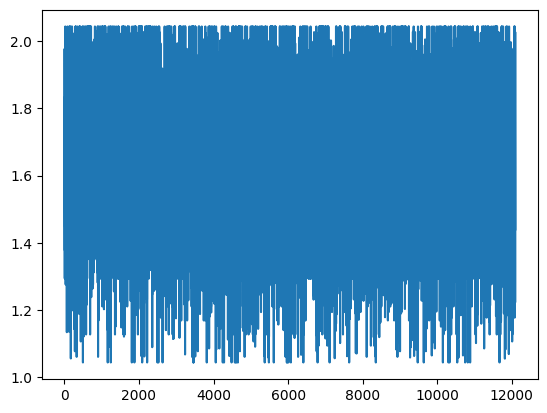

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_list, label='loss')